#### Neuron Initialization
Import modules and setup simulation parameters

In [1]:
from neuron import h
import pandas as pd
import numpy as np
import h5py

from cell_inference.cells.stylizedcell import StylizedCell, CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.ecp import EcpMod, move_position
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.utils.currents.pointcurrent import PointCurrent

from cell_inference.config import params, paths


h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

#### Create simulation
Set parameters

In [2]:
elec_pos = params.ELECTRODE_POSITION #pos = np.column_stack((x,y,z))
loc_param = [50,0,0,np.pi/4,1,0]  # example position
geo_param = [6,600.,.5,.2,.4,200.]  # choose trunk length [-1,600], bounds([3,12],[20,800],[0.2,1.0],[0.2,1.0],[0.2,1.0],[100,300])

# Change the Cell Type Here
cell_type = CellTypes.ACTIVE

if cell_type == CellTypes.ACTIVE:
    biophys = [-1]#,-1,0.0000589*3,-1,0.0213*1.5]
    sim = Simulation(geometry = geo_standard, 
                     electrodes = elec_pos, 
                     cell_type = CellTypes.ACTIVE, 
                     loc_param = loc_param, 
                     geo_param = geo_param, 
                     biophys = biophys, 
                     gmax = .005, 
                     scale = 100000.)  # 0.001 -0.012
else:
    hf = h5py.File(paths.INVIVO2D_DATA_FILE, 'r')
    groundtruth_lfp = np.array(hf.get('data'))
    hf.close()
    maxIndx = np.argmax(np.absolute(groundtruth_lfp).max(axis=0))  # find maximum absolute value from averaged traces
    maxTrace = -groundtruth_lfp[params.START_IDX:,maxIndx]
    soma_injection = np.insert(maxTrace,0,0.)
    soma_injection = np.asarray([s * params.SOMA_INJECT_SCALING_FACTOR for s in soma_injection])
    sim = Simulation(geometry = geo_standard,
                     electrodes = params.ELECTRODE_POSITION,
                     cell_type = CellTypes.PASSIVE, 
                     loc_param = loc_param,
                     geo_param = geo_param,
                     soma_injection = soma_injection,
                     ncell = 1) 

Record membrane voltage at initial/middle/end of the trunk and middle of the tuft to check the propagation.

In [3]:
cell = sim.cells[0]
sec_names = [sec.name().split('.')[-1] for sec in cell.all]
tr_idx = sec_names.index('trunk')
tr_seg_idx0 = cell.sec_id_in_seg[tr_idx]
tr_sec = cell.all[tr_idx]
tr_nseg = tr_sec.nseg
print('%d segments in the trunk.' % (tr_nseg))
tr_seg_idx = range(tr_seg_idx0,tr_seg_idx0+tr_nseg)
tr_segs = cell.get_seg_by_id(tr_seg_idx)
dend_v = Recorder(tr_segs)
soma_v = cell.v()

20 segments in the trunk.


In [4]:
sim.run_neuron_sim()
lfp = sim.get_lfp().T
t = sim.t()

In [5]:
v_dend = dend_v.as_numpy()
seg_v = np.vstack((soma_v,v_dend))
axial_r = np.array([[seg.ri() for seg in tr_segs]]).T
axial_current = np.diff(seg_v,n=1,axis=0)/axial_r
net_axial_current = np.diff(axial_current,n=1,axis=0)
im = sim.lfp[0].im_rec.as_numpy()[tr_seg_idx,:]
seg_names = [seg.sec.name().split('.')[-1] + '(%g)' % (seg.x) for seg in [cell.soma(0.5)]+tr_segs]

Plot membrane voltage in soma, trunk and tuft.

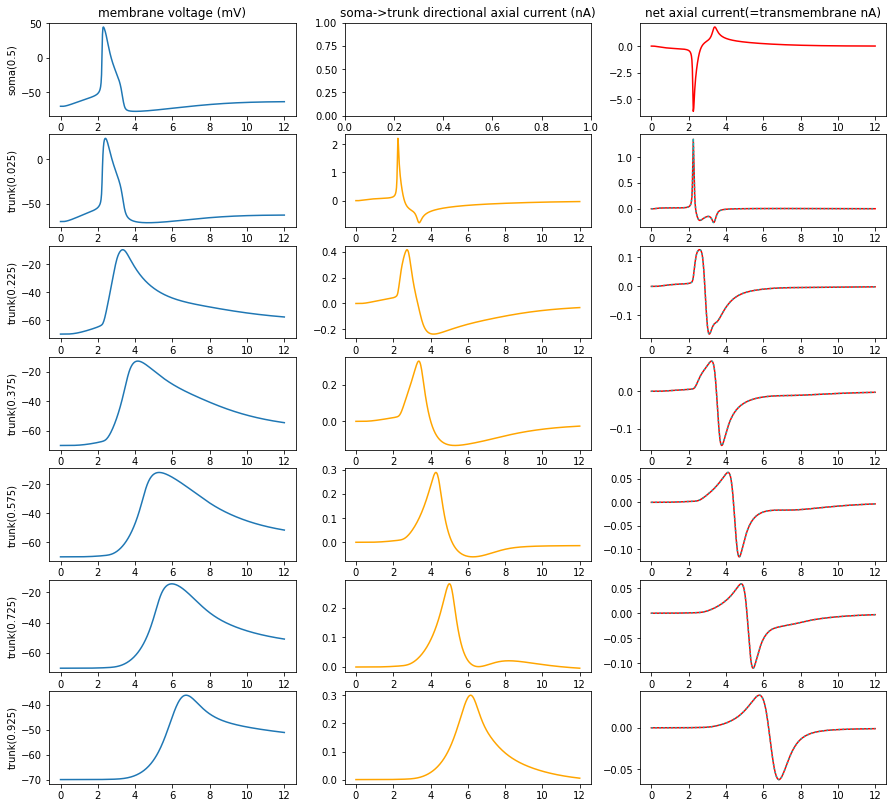

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

window = [0,12]
t_idx = (t>=window[0]) & (t<=window[1])  # time index

nseg = 6
iseg = np.concatenate(([0],np.round(np.linspace(1,tr_nseg-1,nseg)).astype(int)))
fig, axs = plt.subplots(nrows=nseg+1, ncols=3)
fig.set_size_inches(15,2*(nseg+1))
for i,idx in enumerate(iseg):
    axs[i,0].plot(t[t_idx],seg_v[idx,t_idx])
    axs[i,0].set_ylabel(seg_names[idx])
    if idx>0:
        axs[i,1].plot(t[t_idx],-axial_current[idx-1,t_idx],color='orange')
        axs[i,2].plot(t[t_idx],im[idx-1,t_idx],color='r')
        axs[i,2].plot(t[t_idx],net_axial_current[idx-1,t_idx],linestyle='dotted',color='c')
    else:
        axs[i,2].plot(t[t_idx],sim.lfp[0].im_rec.as_numpy()[0,t_idx],color='r')
axs[0,0].set_title('membrane voltage (mV)')
axs[0,1].set_title('soma->trunk directional axial current (nA)')
axs[0,2].set_title('net axial current(=transmembrane nA)')
plt.show()

Use functions in "utils" module to plot

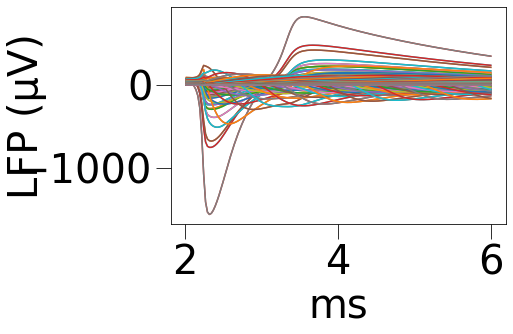

In [7]:
from cell_inference.utils.plotting.plot_results import plot_lfp_traces,plot_lfp_heatmap
%matplotlib inline

delay = 2.0
window = [delay,delay+4.01]
# window = [5.,15.01]
idx = (t>=window[0]) & (t<=window[1])  # time index
fig,ax = plot_lfp_traces(t[idx],lfp[idx,:])

Using column at x = -8 um


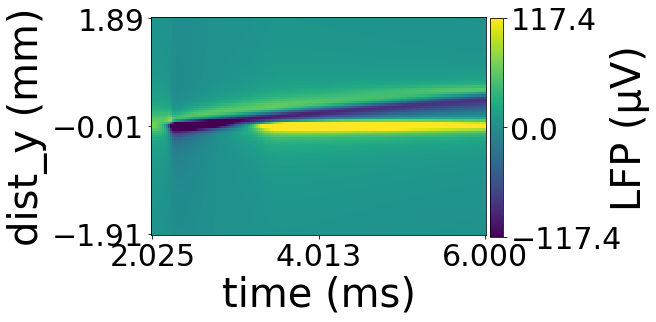

In [8]:
x_dist = np.unique(elec_pos[:,0])
ix = 1
e_idx = elec_pos[:,0]==x_dist[ix] # electrodes index
print('Using column at x = %g um' % (x_dist[ix]))
fig,ax = plot_lfp_heatmap(t[idx],elec_pos[e_idx,1],lfp[idx][:,e_idx],vlim='auto')
# set narrower "vlim" can help see more subtle difference in voltage

In [9]:
help(plot_lfp_heatmap) # check docstring

Help on function plot_lfp_heatmap in module cell_inference.utils.plotting.plot_results:

plot_lfp_heatmap(t: numpy.ndarray, elec_d: numpy.ndarray, lfp: numpy.ndarray, savefig: Union[str, NoneType] = None, vlim: str = 'auto', fontsize: int = 40, ticksize: int = 30, labelpad: int = -12, nbins: int = 3, cbbox: Union[List[float], NoneType] = None, cmap: str = 'viridis') -> Tuple[matplotlib.figure.Figure, matplotlib.axes._axes.Axes]
    Plot LFP heatmap.
    t: time points (ms). 1D array
    elec_d: electrode distance (um). 1D array
    lfp: LFP traces (uV). If is 2D array, each column is a channel.
    savefig: if specified as string, save figure with the string as file name.
    vlim: value limit for color map, using +/- 3-sigma of lfp for bounds as default. Use 'max' for maximum bound range.
    fontsize: size of font for display
    labelpad: Spacing in points from the Axes bounding box including ticks and tick labels.
    tick_length: length between ticks
    nbins: number of bins to c